# Importing the important libraries

In [23]:
import pandas as pd
import pymongo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.functions import lower, regexp_replace
from nltk.tokenize import word_tokenize
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta


from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, TimestampType, FloatType, DoubleType

from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')


# Data Pre-processing techniques

# Accessing the dataset

In [5]:
df = pd.read_csv("Tweets.csv")

# Header of dataset

In [6]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,5,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


# Columns tag

In [7]:
df = df.iloc[:, 1:]

df.columns = ["id", "date", "flag", "user", "text"]

#df.to_csv("Ready_Tweets.csv", index=False)

In [8]:
df.head()

,id,date,flag,user,text
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [9]:
df['date'].head()

0    Mon Apr 06 22:19:49 PDT 2009
1    Mon Apr 06 22:19:53 PDT 2009
2    Mon Apr 06 22:19:57 PDT 2009
3    Mon Apr 06 22:19:57 PDT 2009
4    Mon Apr 06 22:20:00 PDT 2009
Name: date, dtype: object

In [10]:
# Remove 'PDT' from the 'date' column
df['date'] = df['date'].str.replace('PDT', '', regex=False)


In [11]:
df

,id,date,flag,user,text
0,1467810672,Mon Apr 06 22:19:49 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,1467810917,Mon Apr 06 22:19:53 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,1467811184,Mon Apr 06 22:19:57 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,1467811193,Mon Apr 06 22:19:57 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,1467811372,Mon Apr 06 22:20:00 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...
1599994,2193601966,Tue Jun 16 08:40:49 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,2193601969,Tue Jun 16 08:40:49 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,2193601991,Tue Jun 16 08:40:49 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,2193602064,Tue Jun 16 08:40:49 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


# Sentiment Analysis with TextBlob and Vader using Pyspark and MongoDB

In [9]:
# Create a Spark session
spark = SparkSession.builder.appName("TwitterSentimentAnalysis").getOrCreate()


23/10/22 16:35:53 WARN Utils: Your hostname, College resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/10/22 16:35:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/22 16:35:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
# Define the schema for your data
schema = StructType([
    StructField("index", IntegerType(), True),
    StructField("id", IntegerType(), True),
    StructField("date", StringType(), True),
    StructField("flag", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True)
])

# Load the CSV data into a DataFrame
tweets_df = spark.read.csv("Tweets.csv", header=True, schema=schema)


In [11]:
# Create a temporary table for your DataFrame
tweets_df.createOrReplaceTempView("tweets")

In [12]:
# Example: Select top 10 tweets
top_10_tweets = spark.sql("SELECT * FROM tweets LIMIT 10")
top_10_tweets.show()

23/10/22 16:36:23 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: 0, 1467810369, Mon Apr 06 22:19:45 PDT 2009, NO_QUERY, _TheSpecialOne_, @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: index, id, date, flag, user, text
Expected: index but found: 0
CSV file: file:///home/muhammad/Downloads/Tweets.csv


+-----+----------+--------------------+--------+---------------+--------------------+
|index|        id|                date|    flag|           user|                text|
+-----+----------+--------------------+--------+---------------+--------------------+
|    1|1467810672|Mon Apr 06 22:19:...|NO_QUERY|  scotthamilton|is upset that he ...|
|    2|1467810917|Mon Apr 06 22:19:...|NO_QUERY|       mattycus|@Kenichan I dived...|
|    3|1467811184|Mon Apr 06 22:19:...|NO_QUERY|        ElleCTF|my whole body fee...|
|    4|1467811193|Mon Apr 06 22:19:...|NO_QUERY|         Karoli|@nationwideclass ...|
|    5|1467811372|Mon Apr 06 22:20:...|NO_QUERY|       joy_wolf|@Kwesidei not the...|
|    6|1467811592|Mon Apr 06 22:20:...|NO_QUERY|        mybirch|         Need a hug |
|    7|1467811594|Mon Apr 06 22:20:...|NO_QUERY|           coZZ|@LOLTrish hey  lo...|
|    8|1467811795|Mon Apr 06 22:20:...|NO_QUERY|2Hood4Hollywood|@Tatiana_K nope t...|
|    9|1467812025|Mon Apr 06 22:20:...|NO_QUERY|      

In [13]:
total_rows = tweets_df.count()
print("Total rows in the dataset:", total_rows)

Total rows in the dataset: 1599999


In [14]:
tweets_df.printSchema()

root
 |-- index: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- user: string (nullable = true)
 |-- text: string (nullable = true)



In [15]:
# Text preprocessing
tweets_df = tweets_df.withColumn("text", lower(tweets_df["text"]))
tweets_df = tweets_df.withColumn("text", regexp_replace(tweets_df["text"], "[^a-zA-Z\\s]", ""))

In [16]:
# Define a UDF to perform sentiment analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

sentiment_udf = udf(get_sentiment, DoubleType())
tweets_df = tweets_df.withColumn("sentiment", sentiment_udf(tweets_df["text"]))

# Show the results
tweets_df.select("text", "sentiment").show()

23/10/22 16:36:44 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
CSV file: file:///home/muhammad/Downloads/Tweets.csv
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+--------------------+--------------------+
|                text|           sentiment|
+--------------------+--------------------+
|is upset that he ...|                 0.0|
|kenichan i dived ...|                 0.5|
|my whole body fee...|                 0.2|
|nationwideclass n...|              -0.625|
|kwesidei not the ...|                 0.2|
|         need a hug |                 0.0|
|loltrish hey  lon...|  0.2733333333333333|
|tatianak nope the...|                 0.0|
|twittera que me m...|                 0.0|
|spring break in p...|-0.21428571428571427|
|i just repierced ...|                 0.0|
|caregiving i coul...|                 0.0|
|octolinz it it co...|                 0.0|
|smarrison i would...|               0.075|
|iamjazzyfizzle i ...|                 0.0|
|hollis death scen...|                 0.0|
|about to file taxes |                 0.0|
|lettya ahh ive al...|                 0.5|
|fakerpattypattz o...|                 0.0|
|alydesigns i was ...|          

In [41]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/muhammad/nltk_data...


True

In [17]:
# Initialize the NLTK SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Define a User Defined Function (UDF) to perform sentiment analysis
def analyze_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    if sentiment['compound'] >= 0.05:
        return "Positive"
    elif sentiment['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

sentiment_udf = udf(analyze_sentiment, StringType())

# Add a new column 'sentiment' to the DataFrame
tweets_df = tweets_df.withColumn("sentiment", sentiment_udf(tweets_df["text"]))

# Show the results
tweets_df.select("text", "sentiment").show()


23/10/22 16:36:55 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
 Schema: text
Expected: text but found: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
CSV file: file:///home/muhammad/Downloads/Tweets.csv
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|is upset that he ...| Negative|
|kenichan i dived ...| Positive|
|my whole body fee...| Negative|
|nationwideclass n...| Negative|
|kwesidei not the ...|  Neutral|
|         need a hug | Positive|
|loltrish hey  lon...| Positive|
|tatianak nope the...|  Neutral|
|twittera que me m...|  Neutral|
|spring break in p...|  Neutral|
|i just repierced ...|  Neutral|
|caregiving i coul...| Negative|
|octolinz it it co...| Negative|
|smarrison i would...| Positive|
|iamjazzyfizzle i ...| Positive|
|hollis death scen...| Negative|
|about to file taxes |  Neutral|
|lettya ahh ive al...| Positive|
|fakerpattypattz o...| Positive|
|alydesigns i was ...|  Neutral|
+--------------------+---------+
only showing top 20 rows



In [12]:
# Initialize a connection to MongoDB (adjust the connection string as needed)
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["twitter_data"]
collection = db["tweets"]

In [13]:
data = df

In [20]:
# Convert the DataFrame to a list of dictionaries for insertion into MongoDB
tweets = data.to_dict(orient="records")

In [21]:
tweets[0]

{'id': 1467810672,
 'date': 'Mon Apr 06 22:19:49  2009',
 'flag': 'NO_QUERY',
 'user': 'scotthamilton',
 'text': "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"}

In [22]:
total_tweets = len(tweets)
print("Total rows in the dataset:", total_tweets)

Total rows in the dataset: 1599999


In [ ]:
# Insert the data into the MongoDB collection
collection.insert_many(tweets)

In [ ]:
# Retrieve the data from the MongoDB collection
data = list(collection.find())

In [23]:
# Analyze sentiment for each tweet
for tweet in tweets:
    text = tweet["text"]
    analysis = TextBlob(text)
    tweet["sentiment_polarity"] = analysis.sentiment.polarity
    tweet["sentiment_subjectivity"] = analysis.sentiment.subjectivity


In [24]:
for tweet in tweets:
    collection.update_one(
        {"id": tweet["id"]},  # Use a unique identifier (e.g., "_id" field)
        {"$set": {"sentiment_polarity": tweet["sentiment_polarity"], "sentiment_subjectivity": tweet["sentiment_subjectivity"]}}
    )


In [25]:
# Retrieve a few updated results
results = list(collection.find().limit(5))  # Adjust the limit as needed

# Display the updated results
for result in results:
    print(f"Tweet: {result['text']}")
    print(f"Sentiment Polarity: {result['sentiment_polarity']}")
    print(f"Sentiment Subjectivity: {result['sentiment_subjectivity']}")
    print("--------------")

Tweet: is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Sentiment Polarity: 0.0
Sentiment Subjectivity: 0.0
--------------
Tweet: @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Sentiment Polarity: 0.5
Sentiment Subjectivity: 0.5
--------------
Tweet: my whole body feels itchy and like its on fire 
Sentiment Polarity: 0.2
Sentiment Subjectivity: 0.4
--------------
Tweet: @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
Sentiment Polarity: -0.625
Sentiment Subjectivity: 1.0
--------------
Tweet: @Kwesidei not the whole crew 
Sentiment Polarity: 0.2
Sentiment Subjectivity: 0.4
--------------


# Time Series Analysis

In [3]:
# Create a DataFrame from the list of dictionaries
new_df = pd.DataFrame(tweets)

NameError: name 'tweets' is not defined

In [32]:
df_data = new_df.to_csv("Time_Series_data.csv", index=False)

# Accessing dataset for Analysis

In [30]:
time_df = pd.read_csv("Time_Series_data.csv")

In [31]:
time_df

,id,date,flag,user,text,sentiment_polarity,sentiment_subjectivity
0,1467810672,Mon Apr 06 22:19:49 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0.000,0.0000
1,1467810917,Mon Apr 06 22:19:53 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0.500,0.5000
2,1467811184,Mon Apr 06 22:19:57 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0.200,0.4000
3,1467811193,Mon Apr 06 22:19:57 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",-0.625,1.0000
4,1467811372,Mon Apr 06 22:20:00 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,0.200,0.4000
...,...,...,...,...,...,...,...
1599994,2193601966,Tue Jun 16 08:40:49 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,1.000,0.3000
1599995,2193601969,Tue Jun 16 08:40:49 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,0.290,0.5225
1599996,2193601991,Tue Jun 16 08:40:49 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,0.200,0.5000
1599997,2193602064,Tue Jun 16 08:40:49 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,1.000,1.0000


In [32]:
# Assuming "date" is in datetime format, set it as the DataFrame's index
time_df['date'] = pd.to_datetime(time_df['date'])
time_df.set_index('date', inplace=True)

In [33]:
time_df

,id,flag,user,text,sentiment_polarity,sentiment_subjectivity
date,,,,,,
2009-04-06 22:19:49,1467810672,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0.000,0.0000
2009-04-06 22:19:53,1467810917,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0.500,0.5000
2009-04-06 22:19:57,1467811184,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0.200,0.4000
2009-04-06 22:19:57,1467811193,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",-0.625,1.0000
2009-04-06 22:20:00,1467811372,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,0.200,0.4000
...,...,...,...,...,...,...
2009-06-16 08:40:49,2193601966,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,1.000,0.3000
2009-06-16 08:40:49,2193601969,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,0.290,0.5225
2009-06-16 08:40:49,2193601991,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,0.200,0.5000


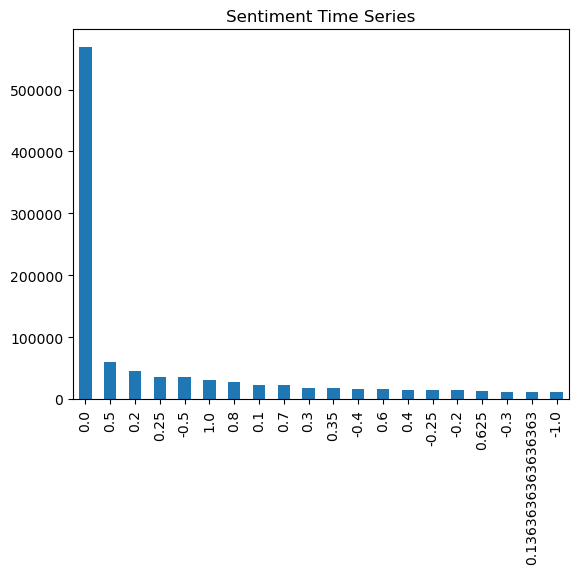

In [6]:
time_df['sentiment_polarity'].value_counts().iloc[:20].plot(title='Sentiment Time Series', kind='bar')
plt.show()

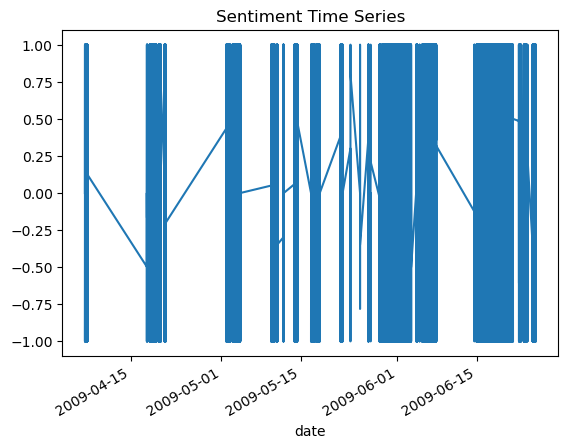

In [7]:
# Create a time series plot to visualize the sentiment data
time_df['sentiment_polarity'].plot(title='Sentiment Time Series')
plt.show()

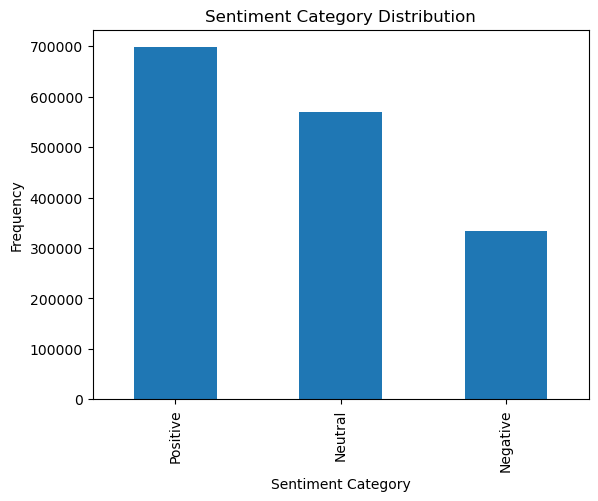

In [8]:
# Categorize sentiment scores
time_df['sentiment_category'] = np.where(time_df['sentiment_polarity'] > 0, 'Positive',
                                      np.where(time_df['sentiment_polarity'] < 0, 'Negative', 'Neutral'))

# Create a bar plot
time_df['sentiment_category'].value_counts().plot(kind='bar')
plt.title('Sentiment Category Distribution')
plt.xlabel('Sentiment Category')
plt.ylabel('Frequency')
plt.show()


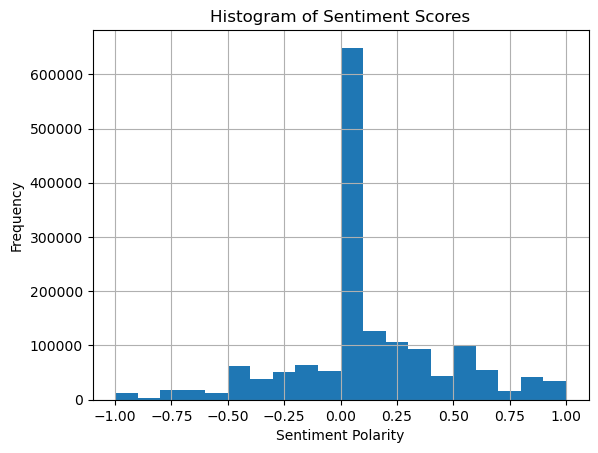

In [6]:
time_df['sentiment_polarity'].hist(bins=20)
plt.title('Histogram of Sentiment Scores')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# Time Forecasting 1 week, 1 month, 3 months

# ARIMA and Exponential Smoothing

In [11]:
# Define the time periods for forecasting
forecast_periods = [7, 30, 90]  # 1 week, 1 month, 3 months

In [12]:
# Perform forecasting and store the results
forecast_results = {
    'ARIMA': [],
    'Exponential Smoothing': []
}

In [13]:
for period in forecast_periods:
    # ARIMA Forecasting
    arima_model = ARIMA(time_df['sentiment_polarity'], order=(5, 1, 0))
    arima_fit = arima_model.fit()
    arima_forecast = arima_fit.forecast(steps=period)

    # Exponential Smoothing (Holt-Winters) Forecasting
    exp_model = ExponentialSmoothing(time_df['sentiment_polarity'], trend='add', seasonal='add', seasonal_periods=7)
    exp_fit = exp_model.fit()
    exp_forecast = exp_fit.forecast(steps=period)

    forecast_results['ARIMA'].append(arima_forecast)
    forecast_results['Exponential Smoothing'].append(exp_forecast)



Forecasts for 7 days:
ARIMA Forecast: 1599999    0.649390
1600000    0.655967
1600001    0.599182
1600002    0.651891
1600003    0.725502
1600004    0.680089
1600005    0.660458
Name: predicted_mean, dtype: float64
Exponential Smoothing Forecast: 1599999    0.203609
1600000    0.255950
1600001    0.230816
1600002    0.332968
1600003    0.151521
1600004    0.229270
1600005    0.226438
dtype: float64



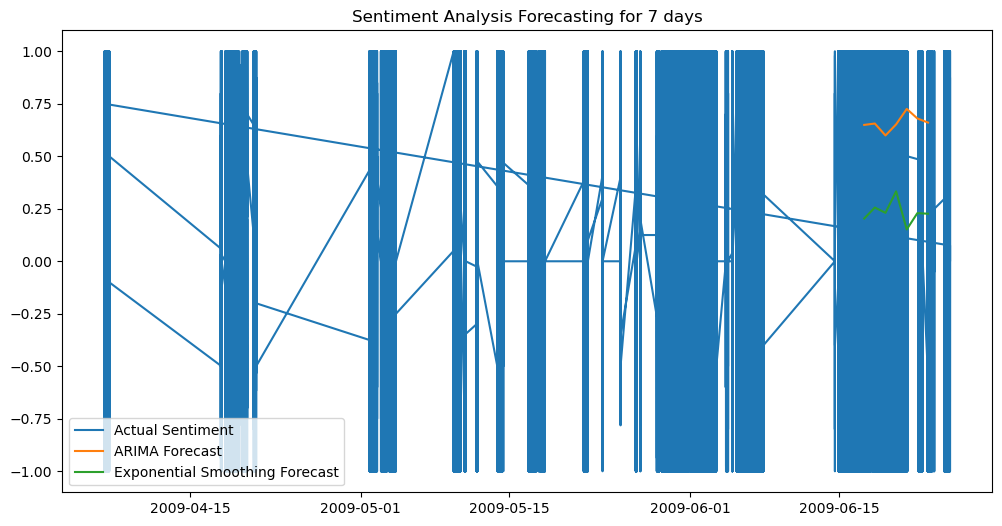

Forecasts for 30 days:
ARIMA Forecast: 1599999    0.649390
1600000    0.655967
1600001    0.599182
1600002    0.651891
1600003    0.725502
1600004    0.680089
1600005    0.660458
1600006    0.662150
1600007    0.663277
1600008    0.673973
1600009    0.677480
1600010    0.669556
1600011    0.667836
1600012    0.669049
1600013    0.670205
1600014    0.671350
1600015    0.670900
1600016    0.669817
1600017    0.669863
1600018    0.670198
1600019    0.670389
1600020    0.670418
1600021    0.670263
1600022    0.670159
1600023    0.670216
1600024    0.670274
1600025    0.670286
1600026    0.670269
1600027    0.670244
1600028    0.670241
Name: predicted_mean, dtype: float64
Exponential Smoothing Forecast: 1599999    0.203609
1600000    0.255950
1600001    0.230816
1600002    0.332968
1600003    0.151521
1600004    0.229270
1600005    0.226438
1600006    0.203901
1600007    0.256242
1600008    0.231109
1600009    0.333261
1600010    0.151814
1600011    0.229563
1600012    0.226730
1600013    0

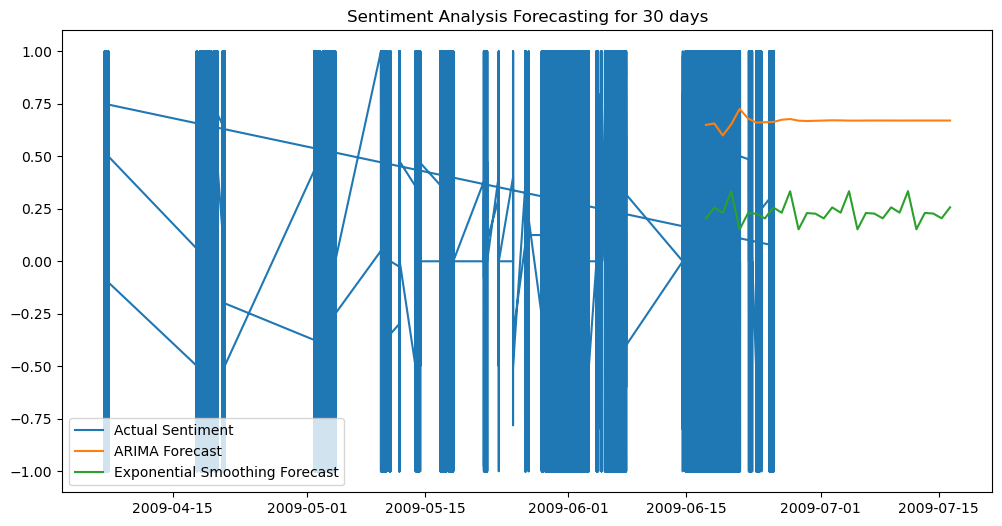

Forecasts for 90 days:
ARIMA Forecast: 1599999    0.649390
1600000    0.655967
1600001    0.599182
1600002    0.651891
1600003    0.725502
             ...   
1600084    0.670256
1600085    0.670256
1600086    0.670256
1600087    0.670256
1600088    0.670256
Name: predicted_mean, Length: 90, dtype: float64
Exponential Smoothing Forecast: 1599999    0.203609
1600000    0.255950
1600001    0.230816
1600002    0.332968
1600003    0.151521
             ...   
1600084    0.259458
1600085    0.234324
1600086    0.336476
1600087    0.155029
1600088    0.232778
Length: 90, dtype: float64



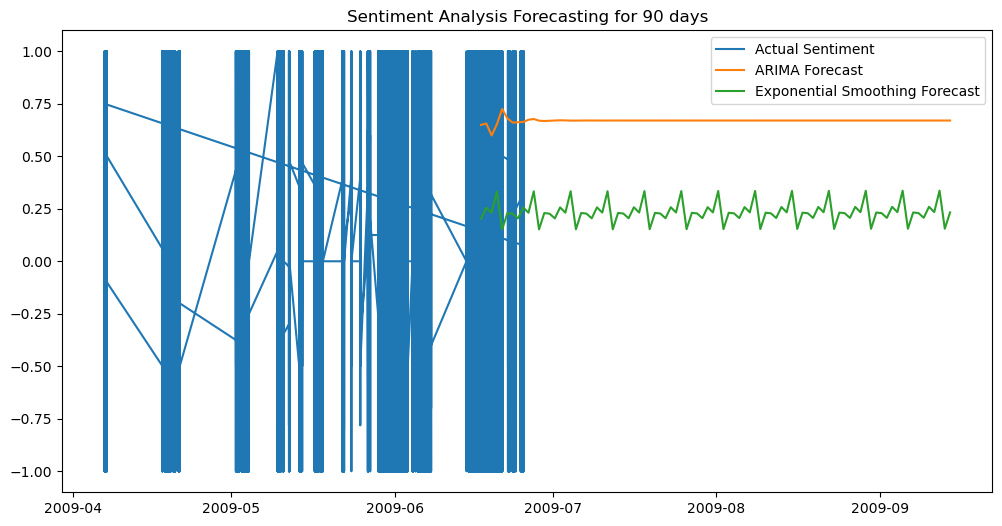

In [14]:
# Print and visualize the forecasts
for i, period in enumerate(forecast_periods):
    print(f"Forecasts for {period} days:")
    print(f"ARIMA Forecast: {forecast_results['ARIMA'][i]}")
    print(f"Exponential Smoothing Forecast: {forecast_results['Exponential Smoothing'][i]}")
    print()

    plt.figure(figsize=(12, 6))
    plt.plot(time_df.index, time_df['sentiment_polarity'], label='Actual Sentiment')
    plt.plot(pd.date_range(start=time_df.index[-1], periods=period + 1, closed='right'), forecast_results['ARIMA'][i], label='ARIMA Forecast')
    plt.plot(pd.date_range(start=time_df.index[-1], periods=period + 1, closed='right'), forecast_results['Exponential Smoothing'][i], label='Exponential Smoothing Forecast')
    plt.legend()
    plt.title(f'Sentiment Analysis Forecasting for {period} days')
    plt.show()

In [41]:
# Split the data into a training set and a testing set
train_size = int(len(time_df) * 0.8)
train, test = time_df[:train_size], time_df[train_size:]

In [43]:
# Normalize the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['sentiment_polarity']])
test_scaled = scaler.transform(test[['sentiment_polarity']])


In [47]:
# Create sequences for the LSTM model
def create_sequences(time_df, sequence_length):
    X, y = [], []
    for i in range(len(time_df) - sequence_length):
        X.append(time_df[i:i+sequence_length])
        y.append(time_df[i+sequence_length])
    return np.array(X), np.array(y)

In [48]:
sequence_length = 10  # You can adjust this based on your dataset and needs
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_test, y_test = create_sequences(test_scaled, sequence_length)

In [49]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [52]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
20000/20000 [==============================] - 117s 6ms/step - loss: 0.0294
Epoch 2/10
20000/20000 [==============================] - 122s 6ms/step - loss: 0.0293
Epoch 3/10
20000/20000 [==============================] - 121s 6ms/step - loss: 0.0292
Epoch 4/10
20000/20000 [==============================] - 120s 6ms/step - loss: 0.0292
Epoch 5/10
20000/20000 [==============================] - 125s 6ms/step - loss: 0.0292
Epoch 6/10
20000/20000 [==============================] - 120s 6ms/step - loss: 0.0292
Epoch 7/10
20000/20000 [==============================] - 117s 6ms/step - loss: 0.0292
Epoch 8/10
20000/20000 [==============================] - 122s 6ms/step - loss: 0.0292
Epoch 9/10
20000/20000 [==============================] - 136s 7ms/step - loss: 0.0292
Epoch 10/10
20000/20000 [==============================] - 126s 6ms/step - loss: 0.0292


In [53]:
# Make predictions
y_pred = model.predict(X_test)

10000/10000 [==============================] - 17s 2ms/step


In [54]:
# Inverse transform the scaled predictions
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

In [55]:
# Calculate the Mean Squared Error (MSE) for the predictions
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")


Mean Squared Error (MSE): 0.11405823296478992


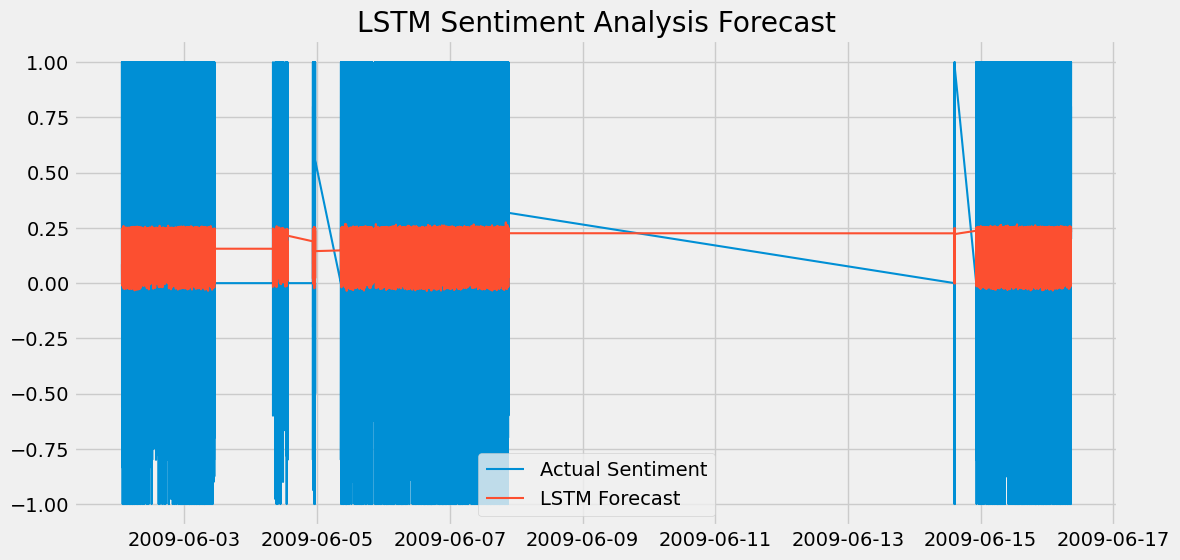

In [56]:
# Visualize the predictions
plt.figure(figsize=(12, 6))
plt.plot(test.index[sequence_length:], y_test, label='Actual Sentiment')
plt.plot(test.index[sequence_length:], y_pred, label='LSTM Forecast')
plt.legend()
plt.title('LSTM Sentiment Analysis Forecast')
plt.show()

# Closing Connection MongoDB and Spark

In [ ]:
# Close the MongoDB connection
client.close()

In [6]:
spark.stop()

In [29]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact


In [35]:
# Load your preprocessed dataset
data = pd.read_csv("Time_Series_data.csv")
data['date'] = pd.to_datetime(data['date'])


In [ ]:
# Define the number of records to display
num_records_to_show = 100

# Create the interactive dashboard
def update_time_series(period, num_records):
    # Filter the data based on the selected time period
    if period == '1 week':
        filtered_data = data.set_index('date').last('1W')
    elif period == '1 month':
        filtered_data = data.set_index('date').last('1M')
    elif period == '3 months':
        filtered_data = data.set_index('date').last('3M')
    
    # Get a subset of the filtered data
    subset_data = filtered_data.head(num_records)
    
    # Create the time series plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=subset_data.index, y=subset_data['sentiment_polarity'], mode='lines', name='Sentiment Polarity'))
    fig.update_layout(title=f'Sentiment Polarity Time Series for the last {period} ({num_records} records)',
                      xaxis_title='Date', yaxis_title='Sentiment Polarity')
    fig.show()

# Define a list of time periods
time_periods = ['1 week', '1 month', '3 months']

# Create an interactive widget for selecting the time period and number of records
interact(update_time_series, period=time_periods, num_records=(1, len(data), 10))
# def update_time_series(period):
#     # Filter the data based on the selected time period
#     if period == '1 week':
#         filtered_data = data.set_index('date').last('1W')
#     elif period == '1 month':
#         filtered_data = data.set_index('date').last('1M')
#     elif period == '3 months':
#         filtered_data = data.set_index('date').last('3M')
    
#     # Create the time series plot
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(x=filtered_data.index, y=filtered_data['sentiment_polarity'], mode='lines', name='Sentiment Polarity'))
#     fig.update_layout(title=f'Sentiment Polarity Time Series for the last {period}', xaxis_title='Date', yaxis_title='Sentiment Polarity')
#     fig.show()

# # Define a list of time periods
# time_periods = ['1 week', '1 month', '3 months']

# # Create an interactive widget for selecting the time period
# interact(update_time_series, period=time_periods);
